In [1]:
library(hdf5r)
library(Seurat)
library(purrr)
library(dplyr)
library(stringr)
library(harmony)
library(DoubletFinder)
library(ggplot2)
library(ggpubr)
library(plyr)
library(pheatmap)

Attaching SeuratObject


载入程辑包：‘purrr’


The following object is masked from ‘package:hdf5r’:

    flatten_df



载入程辑包：‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


载入需要的程辑包：Rcpp

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


载入程辑包：‘plyr’


The following object is masked from ‘package:ggpubr’:

    mutate


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following object is masked from ‘package:purrr’:

    compact




In [2]:
endothelial = readRDS('~/HPV/res/public_rna/seurat_rds/endothelial.rds')

In [3]:
marker_genes = c('SOX17','EFNB2','DKK2','FBLN5','HEY1','IGFBP3','ACKR1','SELP','CPE','POSTN','CCL14','APLN','ESM1','PXDN','PGF','ANGPTL2','APLNR','VWA1','KDR','FLT1','CCL21','PDPN','MADCAM1', 'CSF2RB', 'CLU', 'CPE', 'ADGRG6','PLPP3','HLA-DRA','CXCL10','VCAM1','ICAM1')

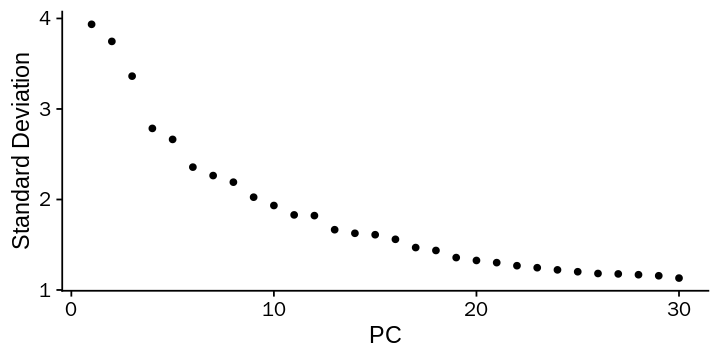

In [4]:
temp = endothelial
endothelial = CreateSeuratObject(counts = endothelial@assays$RNA@counts, project = "endothelial") %>% 
    NormalizeData(verbose = FALSE) %>%
    FindVariableFeatures(selection.method = "vst", nfeatures = 250)
VariableFeatures(endothelial) = unique(c(marker_genes, endothelial@assays$RNA@var.features))
endothelial = ScaleData(endothelial, verbose = FALSE) %>% 
    RunPCA(npcs = 30, verbose = FALSE)
options(repr.plot.width = 6, repr.plot.height = 3)
ElbowPlot(endothelial,ndims = 30)

In [5]:
endothelial@meta.data = temp@meta.data
endothelial = RunHarmony(endothelial, 'Patient', verbose = FALSE) %>%    
    RunUMAP(reduction = "harmony", dims = 1:10, verbose = FALSE) %>%
    FindNeighbors(reduction = "harmony", dims = 1:10, verbose = FALSE) %>%
    FindClusters(resolution = 1.5, verbose = FALSE)

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”
Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


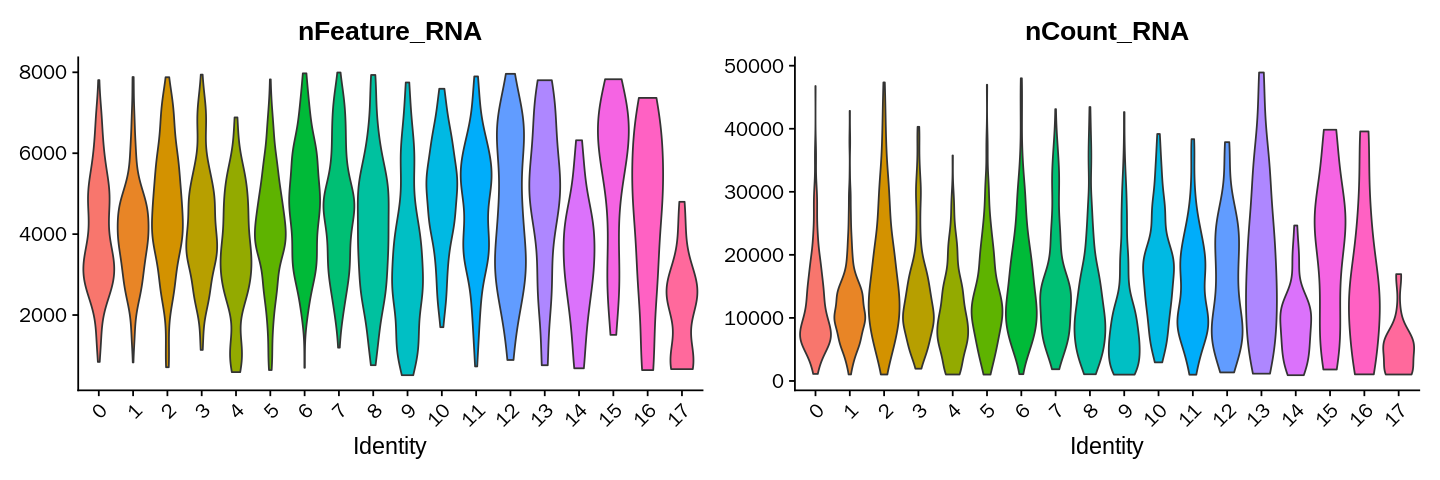

In [6]:
options(repr.plot.width = 12, repr.plot.height = 4)
VlnPlot(endothelial,features = c("nFeature_RNA", "nCount_RNA"),pt.size = 0)

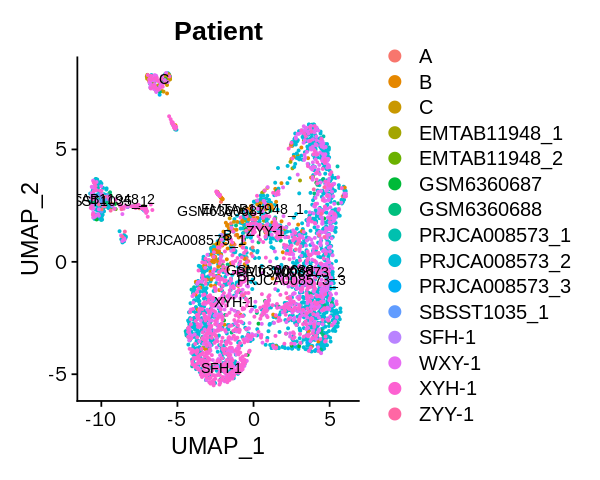

In [7]:
options(repr.plot.width = 5, repr.plot.height = 4)
DimPlot(endothelial, group.by = 'Patient',label = TRUE,label.size = 3)

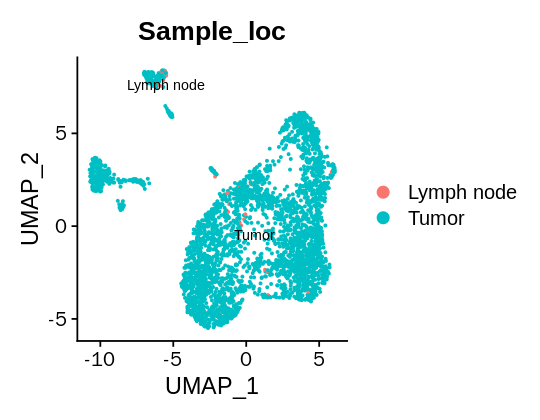

In [8]:
options(repr.plot.width = 4.5, repr.plot.height = 3.5)
DimPlot(endothelial, group.by = 'Sample_loc',label = TRUE,label.size = 3)

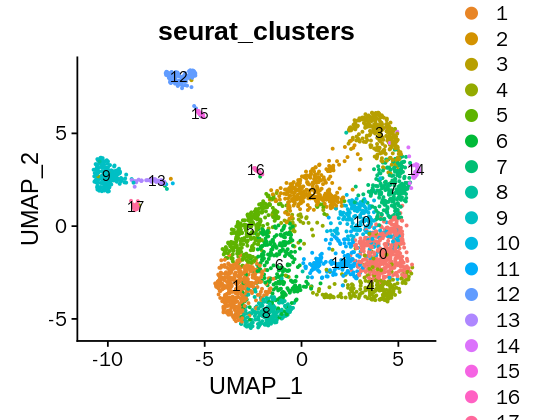

In [9]:
options(repr.plot.width = 4.5, repr.plot.height = 3.5)
DimPlot(endothelial, group.by = 'seurat_clusters',label = TRUE,label.size = 3)

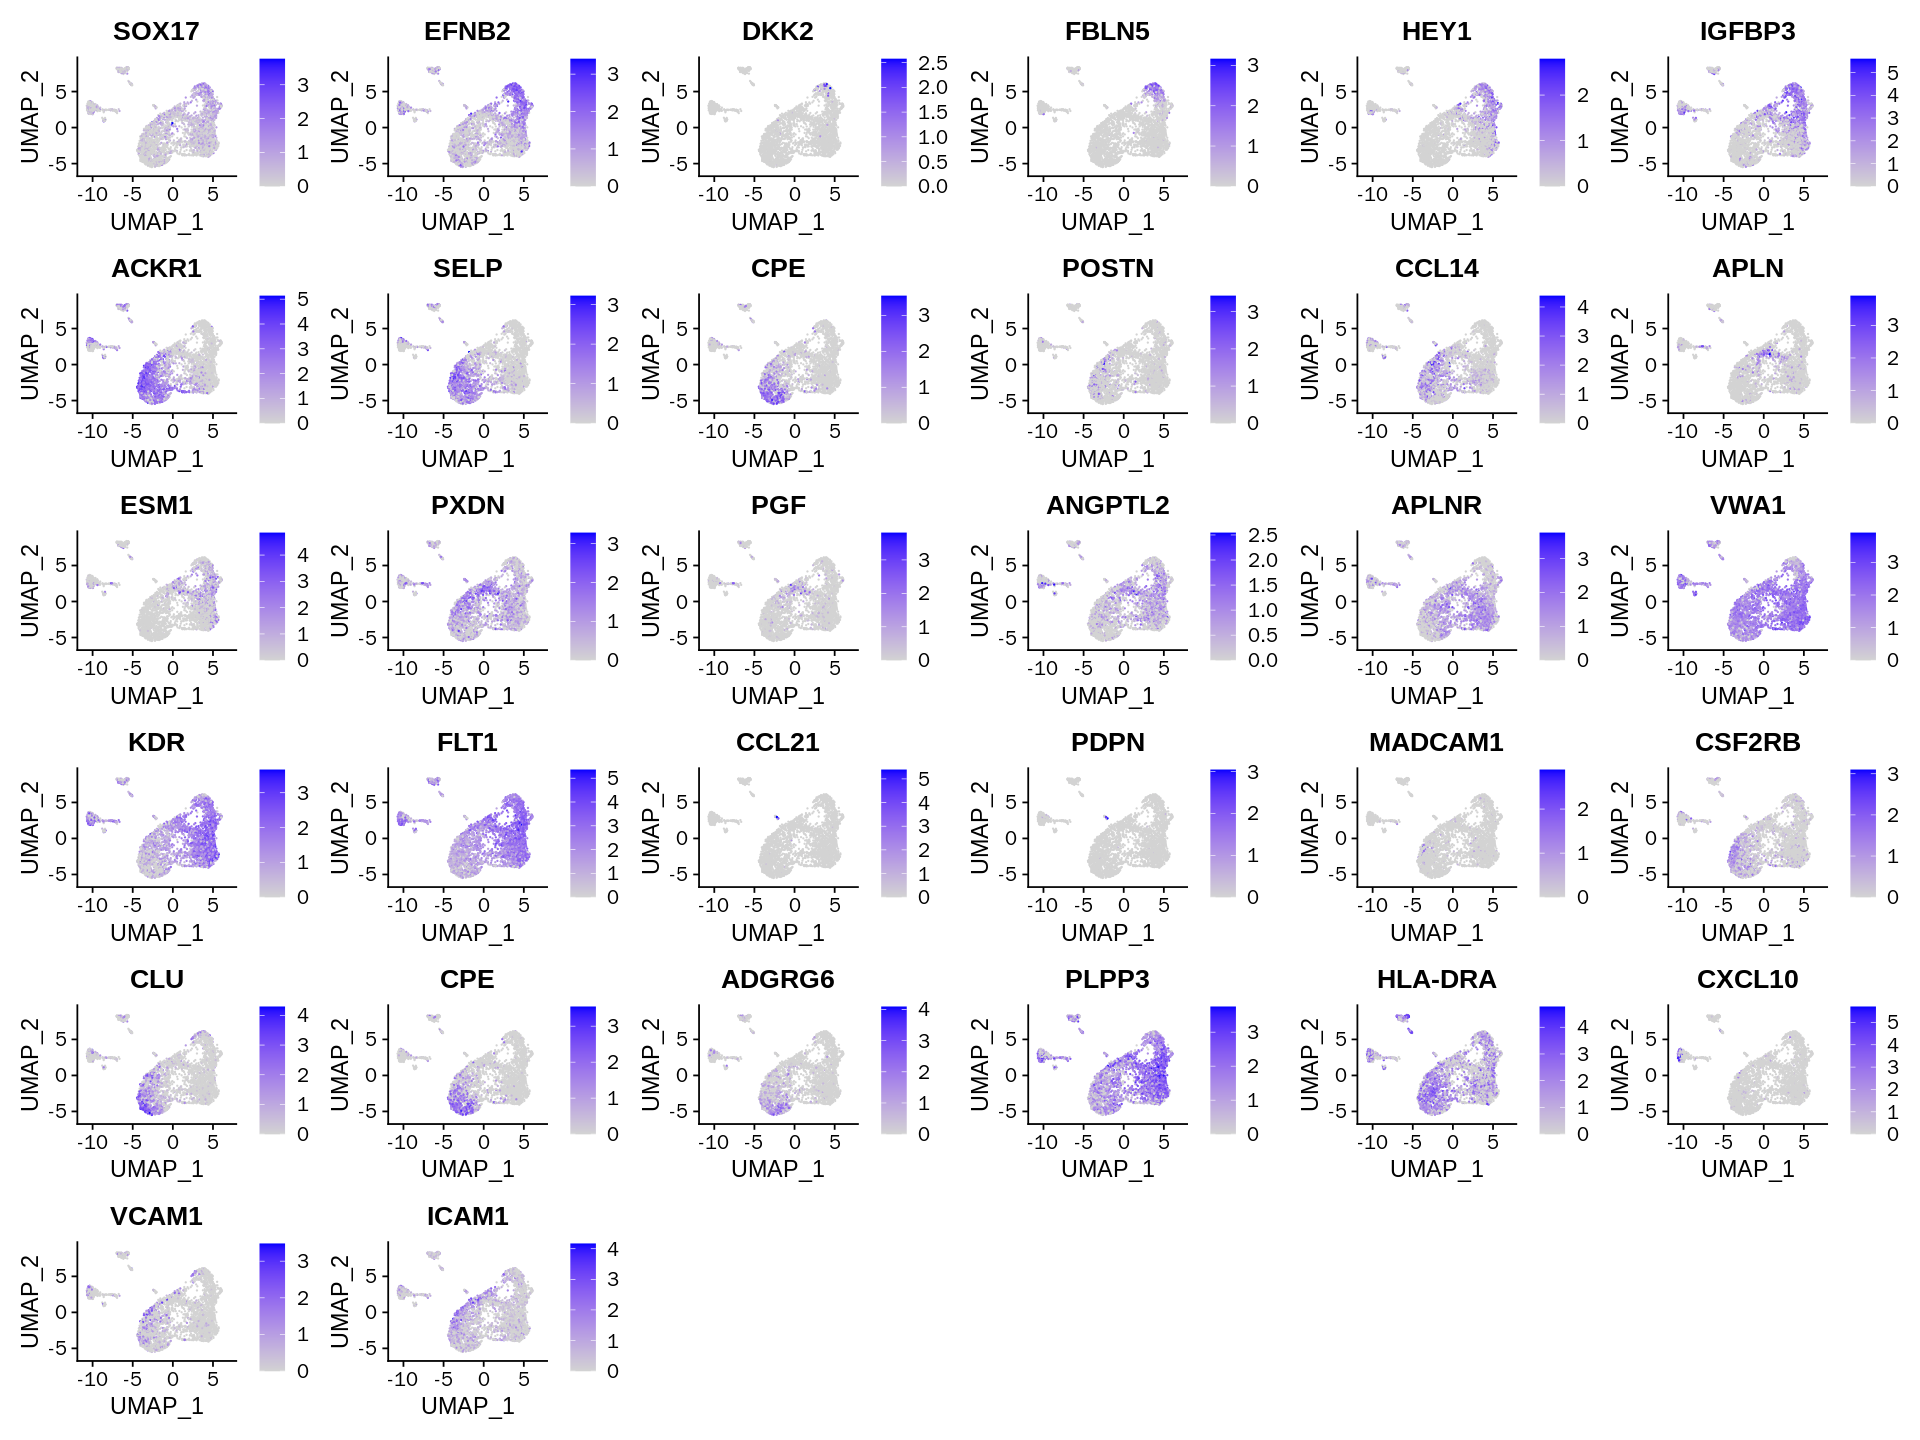

In [10]:
options(repr.plot.width = 16, repr.plot.height = 12)
FeaturePlot(endothelial,features = marker_genes,ncol = 6,pt.size = 0.001)

In [11]:
other_l = c('CD79A','TPSAB1','LILRA4','COL1A2','KRT5','CD68','CSF3R','LILRA4','CLEC9A','CD1C','LAMP3','KIT')
current_l = c("CD3D","CD3E","CD3G","CD4","CD8A","CD8B","FOXP3","KLRD1","GNLY","KLRK1","NKG7",'NCAM1','FCGR3A','NCR3','TRDV2','MKI67')

Warning message in FeaturePlot(endothelial, features = c(other_l, current_l), ncol = 6):
“All cells have the same value (0) of TRDV2.”


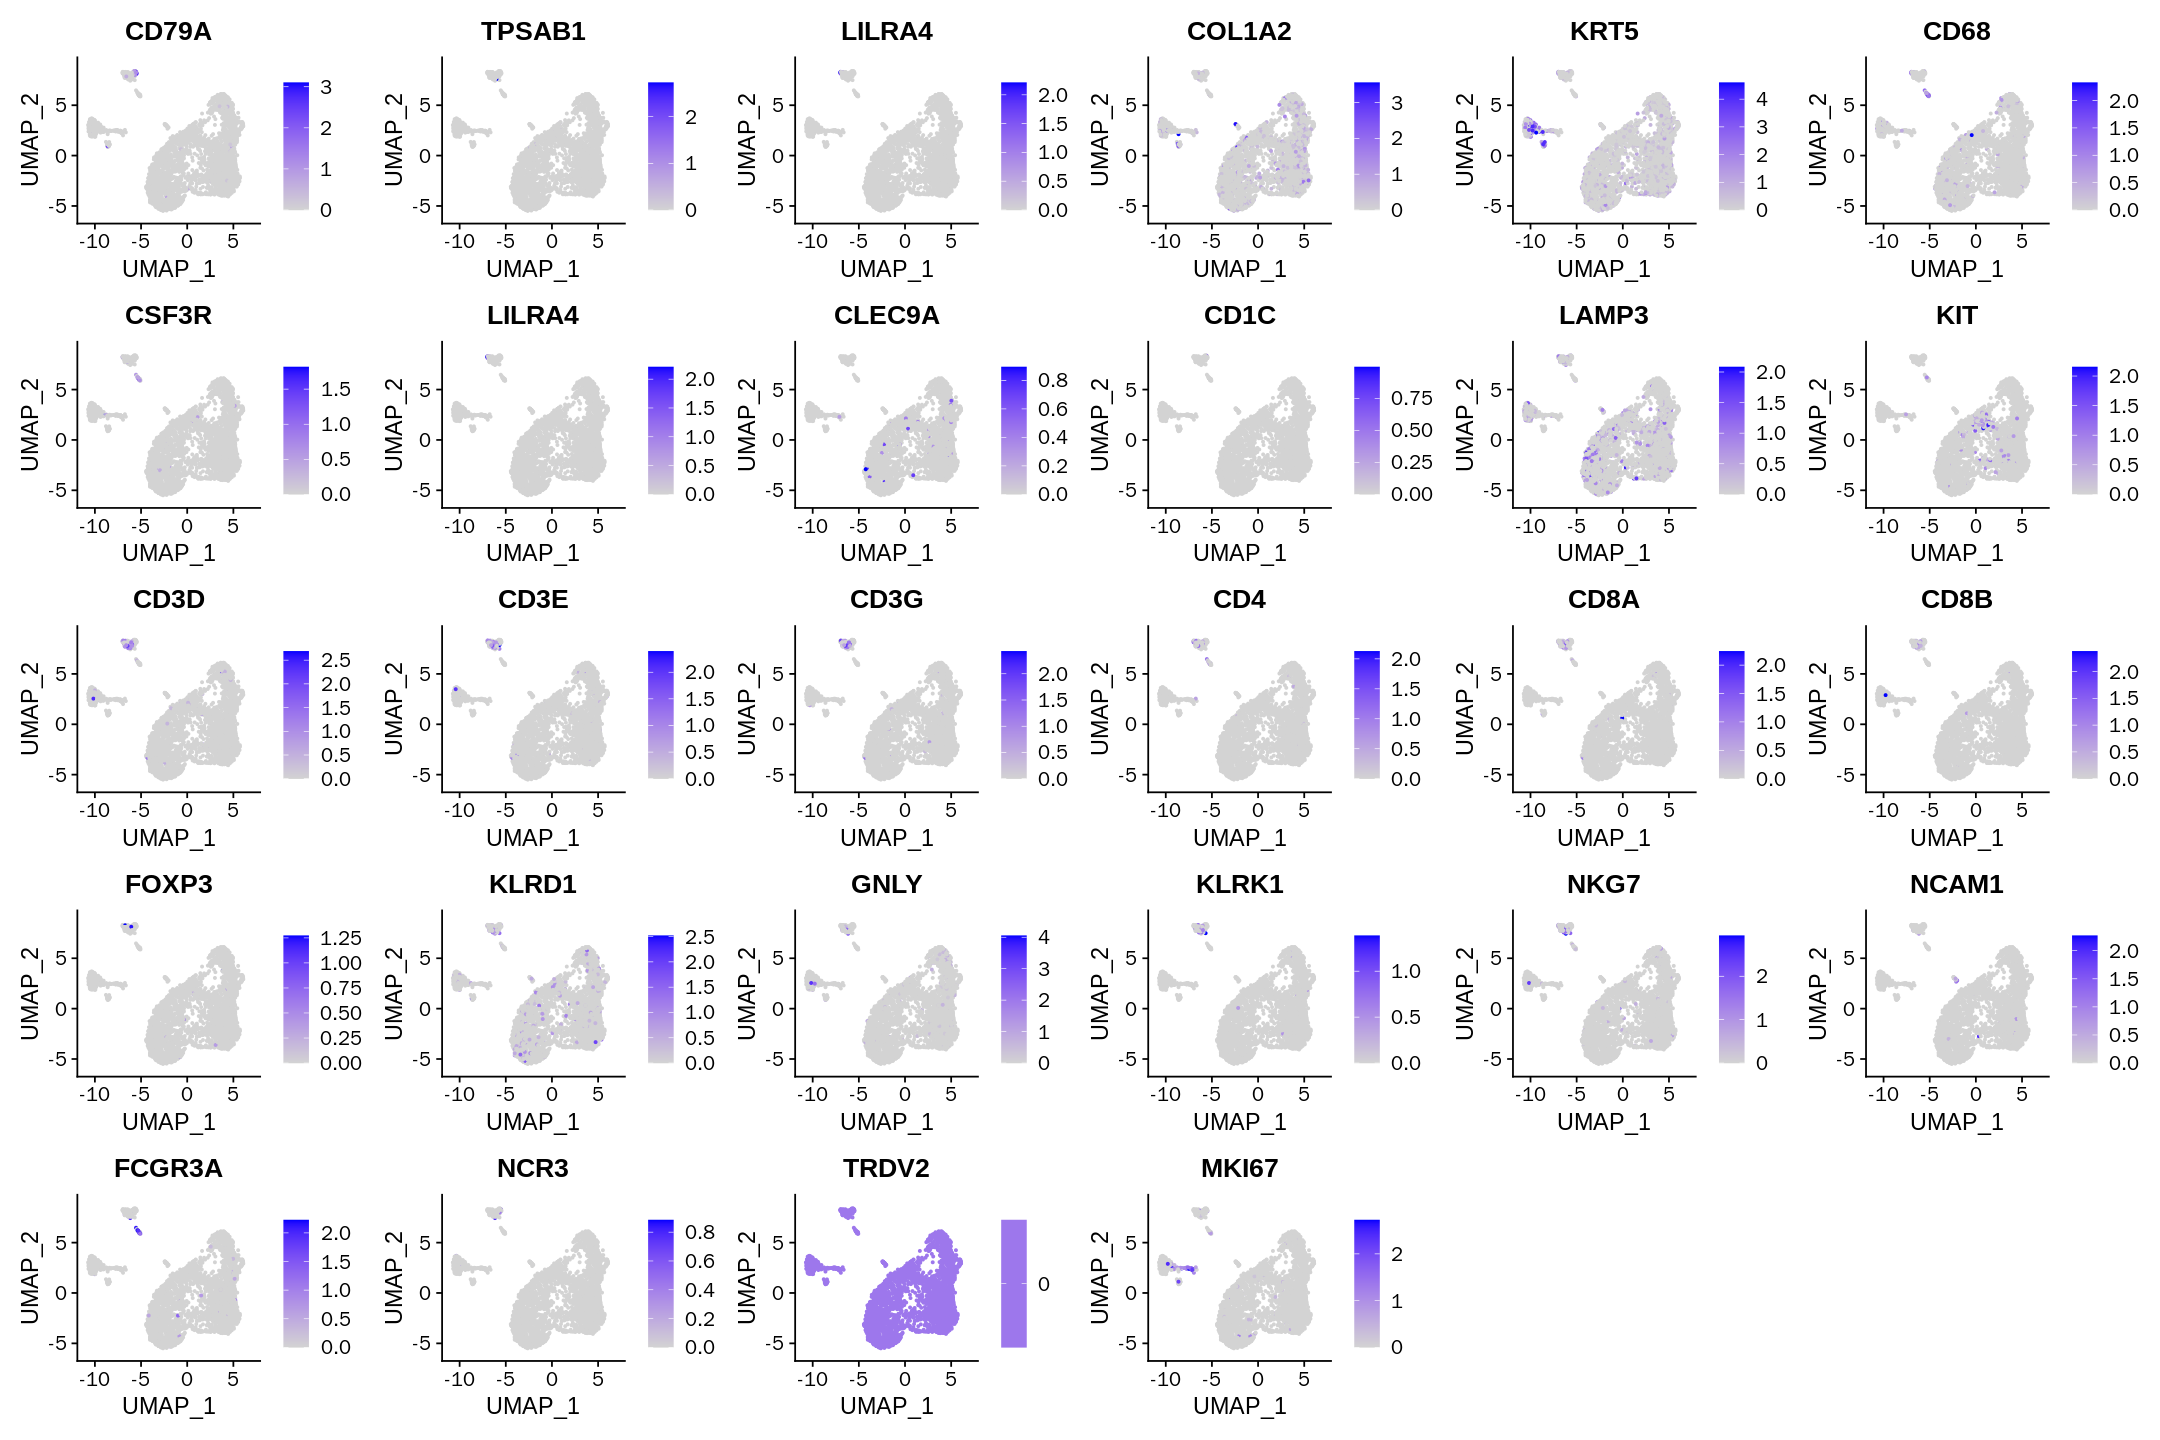

In [12]:
options(repr.plot.width = 18, repr.plot.height = 12)
FeaturePlot(endothelial,features = c(other_l, current_l),ncol = 6)

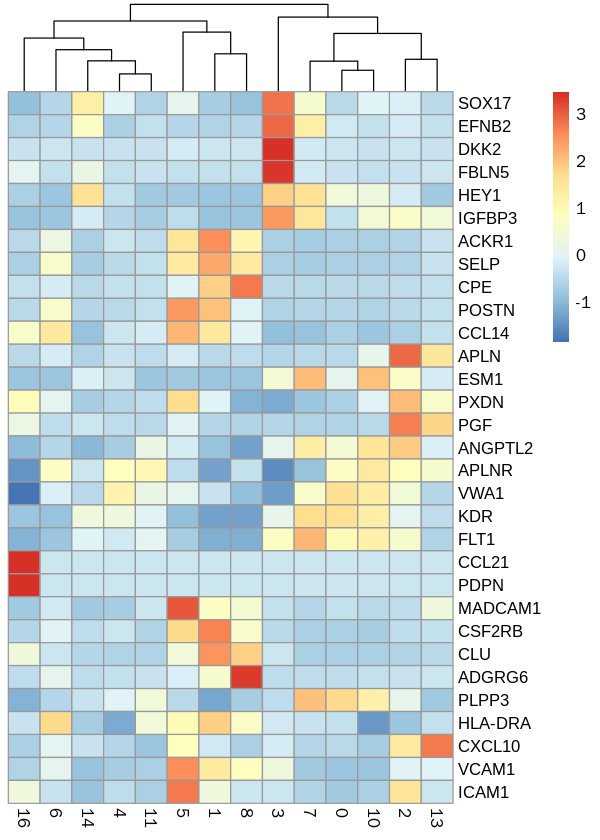

In [13]:
gene_cell_exp <- AverageExpression(endothelial[,!endothelial$seurat_clusters %in% c('9','12','17','15')],
                                   features = c(marker_genes),
                                   group.by = 'seurat_clusters',
                                   slot = 'data') 
gene_cell_exp <- as.data.frame(gene_cell_exp$RNA)
marker_exp <- t(scale(t(gene_cell_exp),scale = T,center = T))
options(repr.plot.width = 5, repr.plot.height = 7)
pheatmap(marker_exp,cluster_rows = FALSE)

In [14]:
endothelial$minor = 'endothelial'
endothelial$minor[endothelial$seurat_clusters %in% c('3','14','7')] = 'EC_Arterial'
endothelial$minor[endothelial$seurat_clusters %in% c('16')] = 'EC_Lymphatic'
endothelial$minor[endothelial$seurat_clusters %in% c('1','8','5')] = 'HEV'
endothelial$minor[endothelial$seurat_clusters %in% c('6')] = 'EC_Vein'
endothelial$minor[endothelial$seurat_clusters %in% c('2','10')] = 'Tip'
endothelial$minor[endothelial$seurat_clusters %in% c('13')] = 'EC_MKI67+'
endothelial$minor[endothelial$seurat_clusters %in% c('0','11','4')] = 'EC_Immature'
endothelial$minor[endothelial$seurat_clusters %in% c('9','12','17','15')] = 'others'

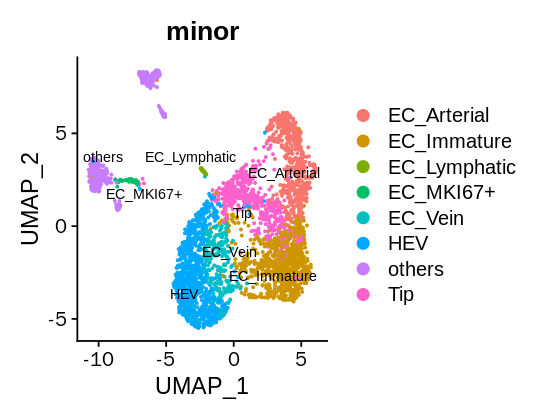

In [15]:
options(repr.plot.width = 4.5, repr.plot.height = 3.5)
DimPlot(endothelial, group.by = 'minor',label = TRUE,label.size = 3,repel = TRUE)

In [16]:
saveRDS(endothelial,file = '~/HPV/res/public_rna/seurat_rds/endothelial.rds')